# Wie hoch ist der Anteil an publizierenden Frauen bei den Verlagen Cotta, Insel und Rotbuch?

Dieses Notebook analysiert den Anteil von publizierenden Frauen in den Verlagen Cotta, Insel und Rotbuch anhand der Katalogdaten des DLA Marbach.

Dieser vereinfachte Lösungsansatz nutzt Solr Join Query, um Titel- und Normdaten zu verknüpfen.

In [1]:
# Bibliotheken importieren
import requests
import pandas as pd
import matplotlib.pyplot as plt

Die Publikationen der jeweiligen Verlage (Cotta, Insel, Rotbuch) können mit einer Suche im Feld `publisher_display_mv` ermittelt werden. Die so ermittelten Publikationsdatensätze beinhalten IDs der Urheber (Personen und Körperschaften) im Feld `creator_id_mv`.

Die Angabe des Geschlechts findet sich nicht in den Publikationsdatensätzen, sondern im Feld `gender` der separaten Personendatensätze (`id:PE*`).

Wir nutzen eine Solr Join Query, um Personen zu finden, die Urheber von Publikationen des Verlags Cotta sind.

## Abfrage der Daten

In [2]:
# Funktion zur Abfrage der Personen-Daten für einen Verlag
def get_gender_data(publisher):
    base_url = "https://dataservice.dla-marbach.de/v1/records"
    params = {
        "q": f"id:PE* AND {{!join from=creator_id_mv to=id}}publisher_display_mv:{publisher}",
        "fields": "id,gender"
    }
    resp = requests.get(base_url, params=params)
    df = pd.DataFrame(resp.json())
    df['publisher'] = publisher
    return df

# Daten für alle drei Verlage abfragen
verlage = ['Cotta', 'Insel', 'Rotbuch']
dfs = [get_gender_data(v) for v in verlage]
df_all = pd.concat(dfs, ignore_index=True)

## Visualisierung

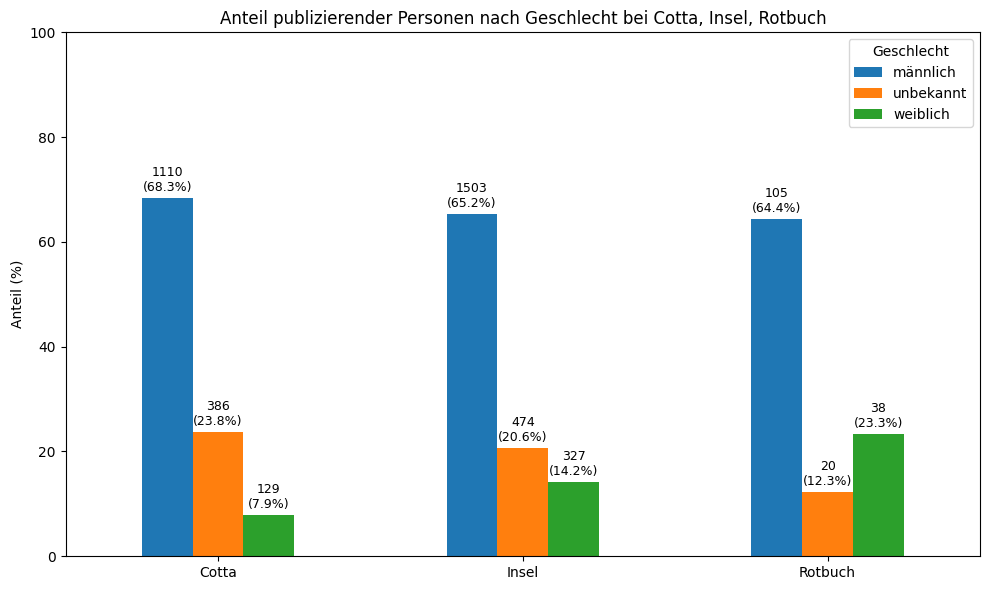

In [14]:
# Für jeden Wert aus gender einen eigenen Balken, Y-Achse = Prozentanteil, Balkenbeschriftung mit Zahl und Prozent
df_all['gender_label'] = df_all['gender'].fillna('unbekannt')

# Gruppieren und Zählen
summary = df_all.groupby(['publisher', 'gender_label']).size().unstack(fill_value=0)
summary_rel = summary.div(summary.sum(axis=1), axis=0) * 100

ax = summary_rel.plot(kind='bar', figsize=(10,6))
plt.title('Anteil publizierender Personen nach Geschlecht bei Cotta, Insel, Rotbuch')
plt.ylabel('Anteil (%)')
ax.set_xlabel('')  # Achsenbeschriftung entfernen
plt.legend(title='Geschlecht')
plt.ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Verlagsnamen horizontal

# Balkenbeschriftung: absolute Zahl und Prozent mit Zeilenumbruch
for bars, gender in zip(ax.containers, summary.columns):
    # Die Reihenfolge der Balken entspricht summary.index (Verlage)
    bar_labels = []
    for i, publisher in enumerate(summary.index):
        abs_val = summary.loc[publisher, gender] if gender in summary.columns else 0
        rel_val = summary_rel.loc[publisher, gender] if gender in summary.columns else 0
        label = f'{abs_val}\n({rel_val:.1f}%)' if rel_val > 0 else ''
        bar_labels.append(label)
    ax.bar_label(bars, labels=bar_labels, padding=3, fontsize=9)

plt.tight_layout()
plt.show()